# Adjusting for competitive advantage — a sensitivity analysis of Tenzi

How do competitive advantages translate into winning chances?

How much of an advantage in one aspect of a game will it take to have a particular chance of winning? For example, between two uneven competitors, how much of a head start would the weaker player need to give them a 50% chance of winning?

I hope you'll come away with at least a couple of ideas:
- Using the concept of a game state to simplify calculations.
- Testing that different approaches that should give the same answer do in fact give the same answer.
- Computing expected winning chances in a head-to-head matchup by using the joint probability distribution of two random variables.

<div align="center">
    <img src="img/visual00.png" alt="Square chart showing the interaction of two distributions, with orange in the lower left indicating where one player wins and purple in the upper right indicating where the other player wins. A curved line of white rectangles separates the two and indicates ties." />
</div>

## Tenzi

Tenzi is a dice rolling game with only a few elements. Each player rolls all ten of their dice; then sets some aside, re-rolls the remainder, and so on until all dice are set aside. The <a href="https://ilovetenzi.com/rules/">official rules</a> of Tenzi provide more specifics:

> Each player chooses a set of dice. Players hold all ten dice in their hands. Someone says "Go" and everyone rolls at the same time. Quickly look at your roll and decide which number you are going to go for. (For example, if you have more 3's than any other number, that’s what you want to go for.) Put all your dice with that number aside, collect the remaining dice and quickly roll again. (You do not have to wait for others to roll again. Everyone rolls together only on the first roll.) Keep rolling until all ten of your dice show the same number.
>
> The first player to get all ten of their dice to match (ten 3's, for example) shouts out "TENZI" and wins the game!

For some games, particularly those where players are racing to solve a puzzle individually (<a href="https://theuzzle.com/">Uzzle</a>, anyone?), my family likes to grant advantages or disadvantages to level the playing field. (I prefer this over <a href="https://github.com/RobinFiveWords/chutes-and-ladders/blob/main/chutes_and_ladders.ipynb">"Daddy goes last."</a>)

I think some players will be significantly faster at rolling, identifying and setting aside the appropriate dice, and being ready to roll again. How does a faster player's chance of winning change based on how much faster they are?

We could compensate by letting a slower player start with fewer dice. How much faster would the faster player need to be to balance a slower player starting with nine dice, so that each has a 50% chance of winning? How about with eight dice?

We'll use simulation and theoretical approaches here. Finding that both agree is valuable confirmation, and any extensions of the problem can be based on whichever approach is more convenient.

### Setup

In [1]:
from collections import Counter, defaultdict
from fractions import Fraction
import random
import sys

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import matplotlib
import pandas as pd  # using once to avoid writing my own complicated function
import sympy

print(f'    Python {sys.version}')
print(f'matplotlib {matplotlib.__version__}')
print(f'    pandas {pd.__version__}')
print(f'     sympy {sympy.__version__}')

    Python 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
matplotlib 3.7.2
    pandas 1.5.3
     sympy 1.12


In [2]:
ORANGE = '#E66100'
PURPLE = '#5D3A9B'
IBM = [
    '#648FFF',
    '#785EF0',
    '#DC267F',
    '#FE6100',
    '#FFB000',
]

Source for colors: <a href="https://davidmathlogic.com/colorblind/">Coloring for Colorblindness</a>

In [3]:
SEED = 'Yahtzee'

## Simulation
We'll write a literal interpretation of the game and make the result of each game be the total number of rolls to finish. Then we'll run 100,000 games and analyze the results.

In [4]:
def get_roll(): return random.randint(1, 6)

def play():
    results = Counter(get_roll() for _ in range(10))
    target_quantity = max(results.values())
    target = random.choice([n for n, qty in results.items() if qty == target_quantity])
    rolls = 1
    total = target_quantity
    while total < 10:
        total += sum(get_roll() == target for _ in range(10 - total))
        rolls += 1
    return rolls

def simulate(n, seed=None):
    if seed:
        random.seed(seed)
    return Counter(play() for _ in range(n))

def weighted_average(counter):
    return sum(k * v for k, v in counter.items()) / sum(counter.values())

In [5]:
simulated_results = simulate(100000, SEED)

In [6]:
format_thousands = lambda x, p: format(int(x), ',')

In [7]:
simul_xs, simul_ys = zip(*sorted(simulated_results.items()))
pct_ys = [y / sum(simul_ys) for y in simul_ys]
cumul_ys = [pct_ys[0]]
for y in pct_ys[1:]:
    cumul_ys.append(y + cumul_ys[-1])

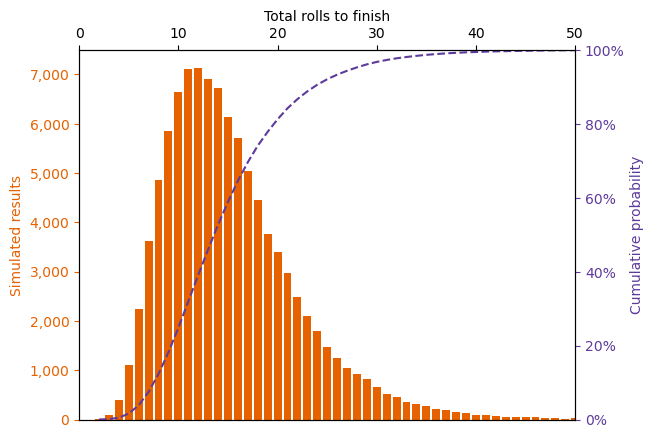

In [8]:
fig0, ax0 = plt.subplots()
# ax0.set_title('Simulated results')
xs0, ys0 = zip(*sorted(simulated_results.items()))
plt.bar(xs0,
        ys0,
        color=ORANGE,)
ax0.set_xlim(0, 50)
ax0.set_xlabel('Total rolls to finish')
ax0.xaxis.tick_top()
ax0.set_ylabel('Simulated results', color=ORANGE)
ax0.xaxis.set_label_position('top')
ax0.tick_params(axis='y', colors=ORANGE)
ax0.yaxis.set_major_formatter(FuncFormatter(format_thousands))

ax0s = ax0.twinx()
plt.plot(simul_xs,
         cumul_ys,
         '--',
         color=PURPLE)
ax0s.set_ylim(0, 1)
ax0s.set_yticks([n/5 for n in range(6)])
ax0s.set_yticklabels([f"{n/5:.0%}" for n in range(6)])
ax0s.tick_params(axis='y', colors=PURPLE)
ax0s.set_ylabel('Cumulative probability', color=PURPLE)
pass;

In [9]:
def percentile(pct, counter):
    total = sum(counter.values())
    cumul = 0
    for roll, freq in sorted(counter.items()):
        cumul += freq
        if pct <= cumul / total:
            return roll

In [10]:
print(f'Simulated average: {weighted_average(simulated_results)}')
print(f'  25th percentile: {percentile(0.25, simulated_results)}')
print(f'  50th percentile: {percentile(0.5, simulated_results)}')
print(f'  75th percentile: {percentile(0.75, simulated_results)}')
print(f'  90th percentile: {percentile(0.9, simulated_results)}')

Simulated average: 15.33951
  25th percentile: 11
  50th percentile: 14
  75th percentile: 19
  90th percentile: 24


From the chart we can see the most common result is 12. The median (50th percentile) is 14 and the weighted average of this right-skewed distribution is over 15.

Before we mess with this distribution for variations between players, let's also take a theoretical approach, to be sure we built the simulation accurately.

## Theoretical approach

The game has two phases. In the first phase, we roll all the dice once, and we figure out which number will be our target. In the second phase, we roll any remaining dice not matching the target. In each phase we'll make use of the concept of a **game state**. When what happens next depends only on where we are now, and not how we got there, we can find a simple way to represent each "where we are now" — this representation, often an ordered list of numbers or just one number, is the game state — and treat all possible games arriving there in a collective fashion.

In the first phase, there are 6<sup>10</sup> = 60,466,176 possible sequences of ten dice rolls, but we do not need to track nearly this many possibilities. What we'll do here is pretend we're rolling one die at a time, and consider the possible game states after each die. Let's think about six-sided dice labeled with letters A through F, rather than with numbers 1 through 6. You might think of this as relabeling the sides of a die numbered 1 through 6 with the letters A through F, in some random order. I'm doing this so that it's more clear that when we use numbers in this section, they represent "how many" and not "which number". Let's look at some of the possibilities after two rolls of these dice.

<img src="img/visual01.png" alt="Tree showing the sequential results of two rolls of a die labeled A through F." />

Two of the possibilities are $AF$ and $FA$. These two are effectively the same result, because the order in which we observe the results does not matter. Recall that in the real game, we roll all ten of these dice at once. It certainly does not matter in which order we look at these ten dice after they're rolled.

Another pair of possibilities is $AF$ and $AE$. These are also effectively the same result. One way to build the intuition for this is that we could just as easily have reversed the labels E and F when randomly labeling the sides A through F. What matters here is that have one each of two different letters. The only possibilities that represent a different case are where the two results matched, such as $AA$. In fact, these are the only two cases after two rolls.

For the first phase, we'll consider the state to be the quantities of each rolled number, sorted in descending order. After the first die, there is only one possible state: $(1)$. After the second die, there are two possible states, either $(2)$ or $(1, 1)$. Whatever that first die was, there's a one-sixth probability the second die is the same, so the probability of $(2)$ is one-sixth and the probability of $(1, 1)$ is five-sixths. Note that there are 6 * 6 = 36 possible outcomes for the first two dice, but only two states that we have to track.

Let's consider the possibilities for the third die, starting from state $(1, 1)$. It could match the first 1. The resulting state would be $(2, 1)$ and would have a probability of five-sixths, its starting probability, times one-sixth. The third die could also match the second 1. Because we sort the quantities in descending order, we also consider this resulting state to be $(2, 1)$, and it would have the same probability. The other four-sixths of the time, the third die will be different than either of the first two, and the resulting state will be $(1, 1, 1)$.

Continuing this approach for all ten dice gives us only 35 final states, and a total of only 125 states throughout. Much simpler to calculate than 60 million possibilities!

In [11]:
ONE = Fraction(1, 1)
SIXTH = Fraction(1, 6)
FIVE_SIXTHS = Fraction(5, 6)
ZERO = Fraction(0, 1)

In [12]:
probabilities = [defaultdict(Fraction) for _ in range(11)]
start = ()
probabilities[0][start] = ONE

for roll in range(1, len(probabilities)):
    for state, prob in probabilities[roll - 1].items():
        for i in range(6):
            before = list(state)
            if i < len(before):
                before[i] += 1
            else:
                before.append(1)
            probabilities[roll][tuple(sorted(before, reverse=True))] += prob * SIXTH

In [13]:
target_probabilities = defaultdict(Fraction)
for state, prob in probabilities[-1].items():
    target_probabilities[state[0]] += prob

In [14]:
for k, v in sorted(target_probabilities.items()):
    print(f"{k:>2}   {f'{float(v):.2%}':>6}   {v.numerator:>6} / {v.denominator}")

 2    6.75%      175 / 2592
 3   52.93%   111125 / 209952
 4   31.05%   130375 / 419904
 5    7.81%    43715 / 559872
 6    1.30%    21875 / 1679616
 7    0.15%      625 / 419904
 8    0.01%      125 / 1119744
 9    0.00%       25 / 5038848
10    0.00%        1 / 10077696


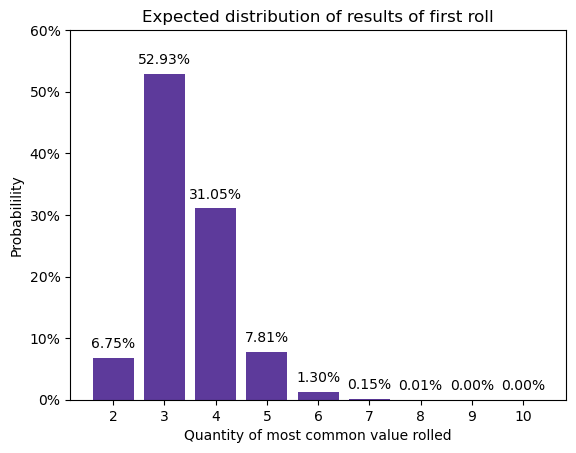

In [15]:
fig, ax = plt.subplots()
ax.set_title('Expected distribution of results of first roll')
xs, ys = zip(*sorted(target_probabilities.items()))
ys = [float(y) for y in ys]
bars = ax.bar(xs, ys, color=PURPLE)
ax.bar_label(bars, fmt="{:.2%}", padding=5)
plt.ylim(0, 0.6)
ax.set_xticks(xs)
ax.set_yticks([n/10 for n in range(7)])
ax.set_yticklabels([f"{n/10:.0%}" for n in range(7)])
plt.xlabel('Quantity of most common value rolled')
plt.ylabel('Probabilility')
pass;

In the second phase, we'll consider the state to be the quantity of dice that already show the target number. For example, if our target number is 3 and we currently have five dice showing 3, we're in state 5. If on our next turn we roll two 3's and three other numbers, we've moved to state 7. If on the turn after that we roll three numbers other than 3, we remain in state 7.

First we'll calculate the probability that a roll from one state moves to each possible state, including the same state. Then we'll multiply our first phase probabilities by this <a href="https://en.wikipedia.org/wiki/Stochastic_matrix">transition matrix</a>, repeatedly for each second phase roll, to compute the probability of winning after each number of rolls. Finally we can compare these results with the distribution from our simulation.

On any given roll in the second phase, we are really only interested in whether or not each die matches the target. This yes-or-no result, this binary result, lends itself to the use of binomial expansion.

In [16]:
binomial_coefficients = [[1]]
for i in range(100):
    previous_row = binomial_coefficients[i]
    previous_length = len(previous_row)
    new_row = [1]
    for j in range(1, previous_length):
        new_row.append(previous_row[j-1] + previous_row[j])
    new_row.append(1)
    binomial_coefficients.append(new_row)

In [17]:
probs = {}
for state in range(2, 11):
    rolling = 10 - state
    _results = {}
    coeffs = binomial_coefficients[rolling]
    for i in range(rolling+1):
        _results[state+i] = (SIXTH ** i) * (FIVE_SIXTHS ** (rolling - i)) * coeffs[i]
    probs[state] = _results

In [18]:
transition_matrix = sympy.Matrix(
    pd.DataFrame.from_dict(probs, orient='index').fillna(ZERO))
transition_matrix

Matrix([
[390625/1679616, 78125/209952, 109375/419904, 21875/209952, 21875/839808,  875/209952, 175/419904,  5/209952, 1/1679616],
[             0, 78125/279936, 109375/279936,  21875/93312, 21875/279936, 4375/279936,  175/93312, 35/279936,  1/279936],
[             0,            0,   15625/46656,    3125/7776,   3125/15552,   625/11664,  125/15552,    5/7776,   1/46656],
[             0,            0,             0,    3125/7776,    3125/7776,    625/3888,   125/3888,   25/7776,    1/7776],
[             0,            0,             0,            0,     625/1296,     125/324,     25/216,     5/324,    1/1296],
[             0,            0,             0,            0,            0,     125/216,      25/72,      5/72,     1/216],
[             0,            0,             0,            0,            0,           0,      25/36,      5/18,      1/36],
[             0,            0,             0,            0,            0,           0,          0,       5/6,       1/6],
[             0

In [19]:
STOP = 250  # max game length we'll compute before visualizations

new_probabilities = [0]
cumulative_probabilities = [0]
state = sympy.Matrix([v for k, v in sorted(target_probabilities.items())]).T
new_probabilities.append(state[-1])
cumulative_probabilities.append(new_probabilities[-1])
for i in range(1, STOP + 1):
    state = state @ transition_matrix
    total = sum(state[:, -1])
    new_probabilities.append(total - cumulative_probabilities[-1])
    cumulative_probabilities.append(total)

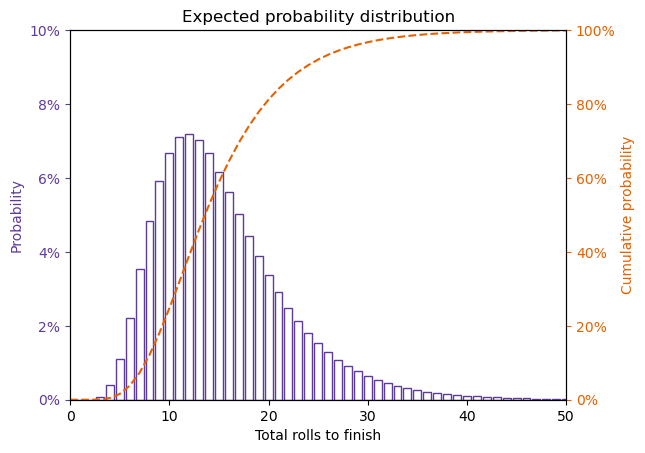

In [20]:
fig2, ax2 = plt.subplots()
ax2.set_title('Expected probability distribution')

new = plt.bar(range(len(new_probabilities)),
              new_probabilities,
              edgecolor=PURPLE,
              fill=None)
ax2.set_xlim(0, 50)
ax2.set_xlabel('Total rolls to finish')
ax2.set_ylim(0, 0.1)
ax2.set_yticks([n/50 for n in range(6)])
ax2.set_yticklabels([f"{n/50:.0%}" for n in range(6)])
ax2.tick_params(axis='y', colors=PURPLE)
ax2.set_ylabel('Probability', color=PURPLE)

ax2s = ax2.twinx()
plt.plot(range(len(cumulative_probabilities)),
         cumulative_probabilities,
         '--',
         color=ORANGE)
ax2s.set_ylim(0, 1)
ax2s.set_yticks([n/5 for n in range(6)])
ax2s.set_yticklabels([f"{n/5:.0%}" for n in range(6)])
ax2s.tick_params(axis='y', colors=ORANGE)
ax2s.set_ylabel('Cumulative probability', color=ORANGE)
pass;

In [21]:
print('Rolls  Probability  Cumulative')
print('-----  -----------  ----------')
for i, (new, cumul) in enumerate(zip(new_probabilities, cumulative_probabilities)):
    if 9 <= i <= 18:
        print(f'{i:>5}  {f"{float(new):.4%}":>11}  {f"{float(cumul):.4%}":>10}')

Rolls  Probability  Cumulative
-----  -----------  ----------
    9      5.9154%    18.0575%
   10      6.6825%    24.7401%
   11      7.1001%    31.8402%
   12      7.1951%    39.0353%
   13      7.0261%    46.0614%
   14      6.6624%    52.7238%
   15      6.1709%    58.8948%
   16      5.6085%    64.5033%
   17      5.0197%    69.5229%
   18      4.4368%    73.9598%


### Simulation vs. Theoretical

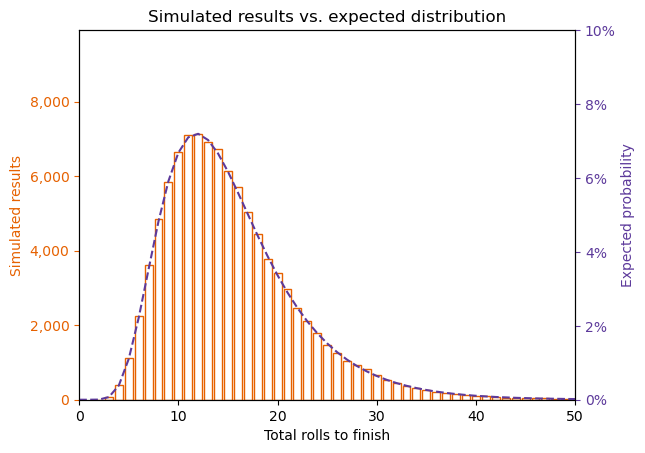

In [22]:
fig3, ax3 = plt.subplots()
ax3.set_title('Simulated results vs. expected distribution')

xs3, ys3 = zip(*sorted(simulated_results.items()))
plt.bar(xs3,
        ys3,
        edgecolor=ORANGE,
        fill=None)
ax3.set_xlim(0, 50)
ax3.set_xlabel('Total rolls to finish')
yscaled = max(ys3) * 0.1 / max(new_probabilities)
ax3.set_ylim(0, int(yscaled))
ax3.tick_params(axis='y', colors=ORANGE)
ax3.yaxis.set_major_formatter(FuncFormatter(format_thousands))
ax3.set_ylabel('Simulated results', color=ORANGE)

ax3s = ax3.twinx()
plt.plot(range(len(new_probabilities)),
         new_probabilities,
         '--',
         color=PURPLE)
ax3s.set_ylim(0, 0.1)
ax3s.set_yticks([n/50 for n in range(6)])
ax3s.set_yticklabels([f"{n/50:.0%}" for n in range(6)])
ax3s.tick_params(axis='y', colors=PURPLE)
ax3s.set_ylabel('Expected probability', color=PURPLE)
pass;

That's a pretty good match!

We can also use a property of an <a href="https://en.wikipedia.org/wiki/Absorbing_Markov_chain">Absorbing Markov chain</a>, which Tenzi and many other games driven purely by chance can be modeled as, to exactly compute the expected number of rolls to win. <a href="https://github.com/RobinFiveWords/chutes-and-ladders/blob/main/chutes_and_ladders.ipynb">If you're into that.</a>

In [23]:
fundamental_matrix = ((sympy.eye(transition_matrix.shape[0] - 1)
                       - transition_matrix[:-1, :-1])
                      .inv())
fundamental_matrix

Matrix([
[1679616/1288991, 174960000000/260132562701, 94918716000000/104833422768503, 535826436746400000/487580249296307453, 60791280443100000/44325477208755223, 891417282146856000/487580249296307453, 121558387497879600/44325477208755223, 2674287490864603920/487580249296307453],
[              0,             279936/201811,            729000000/894628163,           4540284900000/4160915586113,     348382907550000/253815850752893,       464074879635000/253815850752893,      696063601073700/253815850752893,       1392132805895730/253815850752893],
[              0,                         0,                    46656/31031,                   145800000/144325181,              12040650000/8803836041,                  1463940000/800348731,                3449155500/1257690863,                 48287377980/8803836041],
[              0,                         0,                              0,                             7776/4651,                     4050000/3120821,                   5186700

In [24]:
expected_remainders = defaultdict(Fraction)
for i in range(0, 8):
    expected_remainders[i+2] = sum(fundamental_matrix[i, :])
expected_remainders

defaultdict(fractions.Fraction,
            {2: 7512121341839614848/487580249296307453,
             3: 3736509841479198/253815850752893,
             4: 9438928992/677218157,
             5: 3698650986/283994711,
             6: 728256/61061,
             7: 10566/1001,
             8: 96/11,
             9: 6})

In [25]:
expected_length = ZERO
for n, prob in target_probabilities.items():
    expected_length += prob * (ONE + expected_remainders[n])
expected_length

687400143797944474874777/44786196218863024787862

In [26]:
print(f'{expected_length.numerator} / {expected_length.denominator}',
      f'≈ {float(expected_length):.4f}')

687400143797944474874777 / 44786196218863024787862 ≈ 15.3485


## Adjusting parameters for competitive advantage

Because the theoretical approach runs much faster than the simulation, we can use the theoretical approach when exploring adjustments to the game. First we'll wrap all of the above calculations in a `Player` class where we can vary the number of dice and the number of sides on the dice.

In [27]:
class Player:
    def __init__(self, dice, sides):
        self.dice = dice
        self.sides = sides
        self.first_probs = self.get_first_probabilities()
        self.offset = min(freqs[0] for freqs in self.first_probs[-1])
        self.target_probs = self.get_target_probabilities()
        self.trans_probs = self.get_transition_probs()
        self.trans_matrix = self.get_transition_matrix()
        self.new_probs, self.cumul_probs = self.get_new_cumul_probabilities()
        self.fund_matrix = self.get_fundamental_matrix()
        self.exp_remainders = self.get_expected_remainders()
        self.exp_length = self.get_expected_length()
        
    def get_first_probabilities(self):
        nth = ONE / self.sides
        first_probs = [defaultdict(Fraction) for _ in range(self.dice + 1)]
        start = ()
        first_probs[0][start] = ONE
        for roll in range(1, len(first_probs)):
            for state, prob in first_probs[roll - 1].items():
                for i in range(self.sides):
                    working = list(state)
                    if i < len(working):
                        working[i] += 1
                    else:
                        working.append(1)
                    first_probs[roll][tuple(sorted(working, reverse=True))] += prob * nth
        return first_probs

    def get_target_probabilities(self):
        target_probs = defaultdict(Fraction)
        for state, prob in self.first_probs[-1].items():
            target_probs[state[0]] += prob
        return target_probs

    def get_transition_probs(self):
        trans_probs = {}
        nth = ONE / self.sides
        onth = ONE - nth
        for state in range(self.offset, self.dice + 1):
            rolling = self.dice - state
            working = {}
            coeffs = binomial_coefficients[rolling]
            for i in range(rolling + 1):
                working[state + i] = (nth ** i) * (onth ** (rolling - i)) * coeffs[i]
            trans_probs[state] = working
        return trans_probs

    def get_transition_matrix(self):
        return sympy.Matrix(
            pd.DataFrame.from_dict(self.trans_probs, orient='index').fillna(ZERO))

    def get_new_cumul_probabilities(self):
        new_probs = [0]
        cumul_probs = [0]
        state = sympy.Matrix([v for k, v in sorted(self.target_probs.items())]).T
        new_probs.append(state[-1])
        cumul_probs.append(new_probs[-1])
        for i in range(1, STOP + 1):
            state = state @ self.trans_matrix
            total = sum(state[:, -1])
            new_probs.append(total - cumul_probs[-1])
            cumul_probs.append(total)
        return new_probs, cumul_probs

    def get_fundamental_matrix(self):
        return ((sympy.eye(self.trans_matrix.shape[0] - 1)
                 - self.trans_matrix[:-1, :-1])
                .inv())

    def get_expected_remainders(self):
        expected_remainders = defaultdict(Fraction)
        for i in range(self.fund_matrix.shape[0]):
            expected_remainders[i + self.offset] = sum(self.fund_matrix[i, :])
        return expected_remainders

    def get_expected_length(self):
        return sum(prob * (ONE + self.exp_remainders[n])
                   for n, prob in self.target_probs.items())

Let's confirm this matches the previous results.

In [28]:
player = Player(10, 6)

assert player.first_probs == probabilities
assert player.target_probs == target_probabilities
assert player.trans_probs == probs
assert player.trans_matrix == transition_matrix
assert player.new_probs == new_probabilities
assert player.cumul_probs == cumulative_probabilities
assert player.fund_matrix == fundamental_matrix
assert all(player.exp_remainders[r] == expected_remainders[r]
           for r in player.exp_remainders)
assert player.exp_length == expected_length

More broadly, let's make sure the simulation and theoretical approaches are consistent when we change the parameters.

In [29]:
class Simulation:
    def __init__(self, dice, sides):
        self.dice = dice
        self.sides = sides
    
    def get_roll(self): return random.randint(1, self.sides)
    
    def play(self):
        results = Counter(self.get_roll() for _ in range(self.dice))
        target_quantity = max(results.values())
        target = random.choice([n for n, qty in results.items() if qty == target_quantity])
        rolls = 1
        total = target_quantity
        while total < self.dice:
            total += sum(self.get_roll() == target for _ in range(self.dice - total))
            rolls += 1
        return rolls
    
    def run(self, n, seed=None):
        if seed:
            random.seed(seed)
        return Counter(self.play() for _ in range(n))

For various numbers of dice and number of sides on the dice, when we run large enough simulations, we should get an average very close to the theoretical expected value.

In [30]:
print('Dice  Sides  Simulation  Theoretical  Difference')
print('----  -----  ----------  -----------  ----------')
for dice in range(6, 13):
    for sides in range(6, 11):
        sim = Simulation(dice, sides).run(100000)
        pla = Player(dice, sides)
        simulation = weighted_average(sim)
        theoretical = float(pla.exp_length)
        difference = simulation - theoretical
        print(f'{dice:>4d}  {sides:>5d}  {f"{simulation:.4f}":>10}  {f"{theoretical:.4f}":>11}  {f"{difference:.4f}":>10}')

Dice  Sides  Simulation  Theoretical  Difference
----  -----  ----------  -----------  ----------
   6      6     12.3408      12.3329      0.0079
   6      7     14.5109      14.5220     -0.0111
   6      8     16.6875      16.7202     -0.0327
   6      9     18.9159      18.9276     -0.0117
   6     10     21.1511      21.1436      0.0076
   7      6     13.2757      13.2610      0.0146
   7      7     15.6518      15.6209      0.0310
   7      8     18.0038      17.9824      0.0214
   7      9     20.3659      20.3481      0.0178
   7     10     22.7231      22.7191      0.0040
   8      6     14.0559      14.0468      0.0090
   8      7     16.5807      16.5602      0.0205
   8      8     19.0343      19.0724     -0.0381
   8      9     21.5054      21.5845     -0.0791
   8     10     24.0804      24.0980     -0.0176
   9      6     14.7030      14.7323     -0.0293
   9      7     17.3544      17.3745     -0.0201
   9      8     19.9707      20.0192     -0.0485
   9      9     22.6

Now that we can confidently vary the parameters, let's see how the distribution changes if we start from the original game and remove one or more dice. We'll start by graphing the distribution and adding a few points of interest — dots for percentiles and a vertical dashed line for the expected value (average).

In [31]:
def chart_players(players, percentiles=None):
    if isinstance(players, Player):
        players = [players]
    if not percentiles:
        percentiles = []
    else:
        percentiles = sorted(set(percentiles))
    fig, ax = plt.subplots()
    for i, player in enumerate(players):
        color = IBM[i]
        plt.plot(range(len(player.new_probs)),
                 player.new_probs,
                 color=color,
                 label=f"{player.dice} dice, {player.sides} sides")
        plt.axvline(player.exp_length,
                    linestyle='--',
                    color=color)
        cumul = [(j, float(prob)) for j, prob in enumerate(player.cumul_probs)]
        for percentile in percentiles:
            for j, prob in cumul:
                if percentile <= prob:
                    plt.plot(j,
                             player.new_probs[j],
                             'o',
                             color=color)
                    break
    ax.set_xlim(0, 50)
    ax.set_xlabel('Total rolls to finish')
    ax.set_ylim(0, 0.1)
    ax.set_yticks([n/50 for n in range(6)])
    ax.set_yticklabels([f"{n/50:.0%}" for n in range(6)])
    ax.set_ylabel('Probability')
    ax.legend()

Here's how it looks for the regular game:

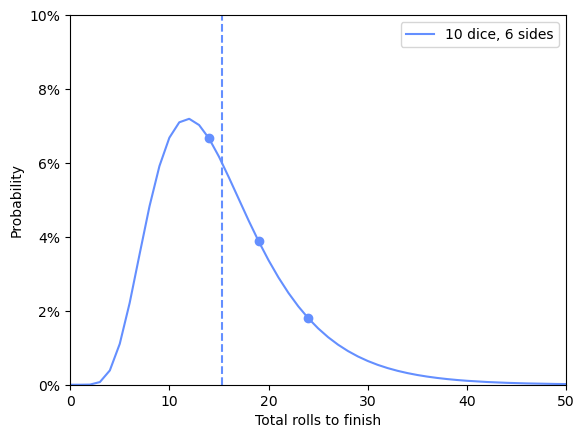

In [32]:
chart_players(Player(10, 6), [0.5, 0.75, 0.9])

And as we remove dice:

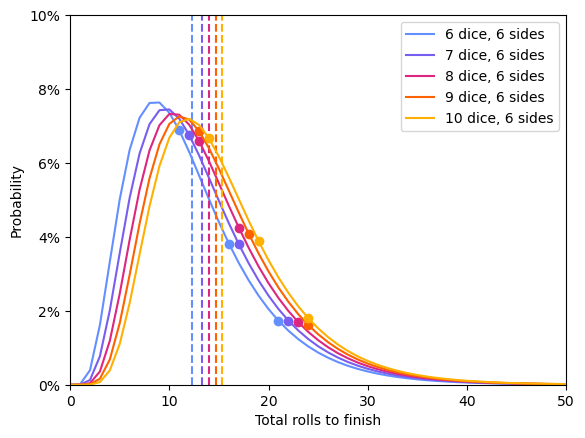

In [33]:
players = [Player(dice, 6) for dice in range(6, 11)]

chart_players(players, [0.5, 0.75, 0.9])

This is pretty but doesn't directly show the expected winning chances between any pair. We need to look at head-to-head matchups between these distributions.

Let's arrange all possibilities for a player along a line. This is like taking the bars in the "Expected probability distribution" chart far above, laying them on their side, and joining them together. The taller bars make up more of the joined line, just as those numbers of total rolls to finish occur with higher probability.

In [34]:
def display_distributions(players, rolls=None, percentiles=None):
    if isinstance(players, Player):
        players = [players]
    if not rolls:
        rolls = []
    else:
        rolls = sorted(set(rolls))
    if not percentiles:
        percentiles = []
    else:
        percentiles = sorted(set(percentiles))
    fig, axes = plt.subplots(nrows=len(players),
                             ncols=1,
                             figsize=(5, 0.4 + len(players)))
    title = "Distributions for players"
    if rolls:
        title += " with specific rolls highlighted"
    elif percentiles:
        title += " with specific percentiles highlighted"
    fig.suptitle(title)
    if isinstance(axes, matplotlib.axes._axes.Axes):
        axes = [axes]
    for ax, player in zip(axes, players):
        index = 0
        for roll, length in enumerate(player.new_probs[1:], start=1):
            pct = None
            if rolls:
                highlight = roll in rolls
                color = ORANGE
            else:  # if percentiles
                pcts = [percentile for percentile in percentiles
                        if player.cumul_probs[roll-1] < percentile <= player.cumul_probs[roll]]
                if pcts:
                    highlight = True
                    pct = sorted(pcts)[-1]
                else:
                    highlight = False
                color = PURPLE
            rectangle = Rectangle((index, 0), length, roll,
                                  edgecolor=color if highlight else 'lightgray',
                                  linewidth=1,
                                  facecolor=color if highlight else 'none')
            ax.add_patch(rectangle)
            if highlight:
                rectangle.set_zorder(10)
                ax.text(index + length / 2, roll + 20,
                        roll,
                        color=color,
                        horizontalalignment='center')
                if pct:
                    text = ax.text(pct, roll + 90,
                                   f"{pct:.0%}",
                                   color=color,
                                   horizontalalignment='center',
                                   bbox={'boxstyle': 'square',
                                         'facecolor': 'white',
                                         'alpha': 0.5,
                                         'edgecolor': color})
                    ax.axvline(pct,
                               ymax=len(player.new_probs),
                               linestyle=':',
                               color=color,
                               alpha=0.3)
            index += length
        ax.set_xlim(0, 1)
        ax.set_ylim(0, roll)
        ax.set_title(f"{player.dice} dice, {player.sides} sides",
                     y=0.66)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
    fig.tight_layout()

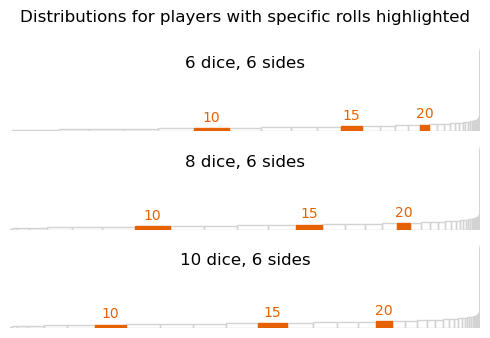

In [35]:
display_distributions(players[::2], rolls=[10, 15, 20])

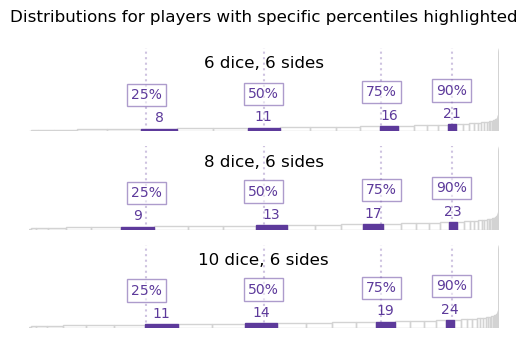

In [36]:
display_distributions(players[::2], percentiles=[0.25, 0.5, 0.75, 0.9])

Then we can create a square from two distributions, with one distribution going across the top and one going down the side. Each point within the square is effectively a random sample from the distributions of each player. Whichever player took fewer rolls to finish would win for that sample. We can then walk through the two distributions to divide the square into three regions: where one player would win, where the other player would win, and where the two would tie.

In [37]:
def get_player_probs(player):
    return [(roll, new, cumul) for roll, (new, cumul) in
            enumerate(zip(player.new_probs, player.cumul_probs))]

In [38]:
def get_wins(player, opponent):
    player_probs = get_player_probs(player)
    opponent_probs = get_player_probs(opponent)
    player_index = 0
    opponent_index = 0
    current_x = ZERO
    current_y = ZERO
    coords = [(current_x, current_y)]
    area = ZERO
    while player_index < len(player_probs) or opponent_index < len(opponent_probs):
        try:
            player_roll, player_new, player_cumul = player_probs[player_index]
        except IndexError:
            player_roll, player_new, player_cumul = float('inf'), ZERO, ONE
        try:
            opponent_roll, opponent_new, opponent_cumul = opponent_probs[opponent_index]
        except IndexError:
            opponent_roll, opponent_new, opponent_cumul = float('inf'), ZERO, ONE
        if player_roll >= opponent_roll:
            area += current_x * opponent_new
            current_y += opponent_new
            opponent_index += 1
        else:  # player_roll < opponent_roll
            current_x += player_new
            player_index += 1
        coords.append((current_x, current_y))
    coords.append((ONE, ONE))
    coords.append((ZERO, ONE))
    coords.append((ZERO, ZERO))
    return coords, area

In [39]:
def show_head_to_head(player1, player2, show=True):
    coords1, area1 = get_wins(player1, player2)
    coords2, area2 = get_wins(player2, player1)
    coords2 = [(y, x) for x, y in coords2]  # transpose
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.invert_yaxis()
    ax.add_patch(Polygon(coords1, color=ORANGE))
    ax.add_patch(Polygon(coords2, color=PURPLE))
    ax.set_xlabel(f"{player1.dice} dice, {player2.sides} sides: {float(area1):.2%}",
                  color=ORANGE)
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(f"{player2.dice} dice, {player2.sides} sides: {float(area2):.2%}",
                  color=PURPLE,
                  labelpad=7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    if show:
        plt.show()
        print(f"{player1.dice:>2} dice, {player1.sides:>2} sides: {f'{float(area1):.2%}':>6}")
        print(f"{player2.dice:>2} dice, {player2.sides:>2} sides: {f'{float(area2):.2%}':>6}")
        print(f"              Tie: {f'{float(ONE - area1 - area2):.2%}':>6}")
    else:
        plt.close()
        return area1, area2, ONE - area1 - area2  # player 1 win, player 2 win, tie

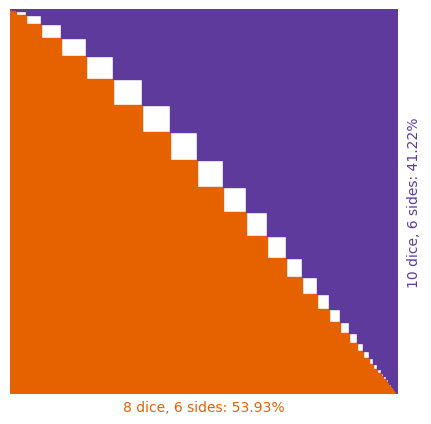

 8 dice,  6 sides: 53.93%
10 dice,  6 sides: 41.22%
              Tie:  4.85%


In [40]:
show_head_to_head(players[2], players[4])

Again, let's make sure simulations agree before we trust the theoretical results.

In [41]:
class SimHeadToHead:
    def __init__(self, dice1, sides1, dice2, sides2):
        self.dice1 = dice1
        self.sides1 = sides1
        self.dice2 = dice2
        self.sides2 = sides2
    
    def get_roll1(self): return random.randint(1, self.sides1)
    def get_roll2(self): return random.randint(1, self.sides2)
    
    def play(self):
        results1 = Counter(self.get_roll1() for _ in range(self.dice1))
        target_quantity1 = max(results1.values())
        target1 = random.choice([n for n, qty in results1.items() if qty == target_quantity1])

        results2 = Counter(self.get_roll2() for _ in range(self.dice2))
        target_quantity2 = max(results2.values())
        target2 = random.choice([n for n, qty in results2.items() if qty == target_quantity2])
        
        total1 = target_quantity1
        total2 = target_quantity2
        while total1 < self.dice1 and total2 < self.dice2:
            total1 += sum(self.get_roll1() == target1 for _ in range(self.dice1 - total1))
            total2 += sum(self.get_roll2() == target2 for _ in range(self.dice2 - total2))
        if total1 == self.dice1:
            if total2 == self.dice2:
                return 0  # tie
            else:
                return -1  # player 1 win
        else:
            return 1  # player 2 win
    
    def run(self, n, seed=None):
        if seed:
            random.seed(seed)
        return Counter(self.play() for _ in range(n))

Theoretical head-to-head results:

In [42]:
for i in range(5):
    r = show_head_to_head(players[i], players[-1], False)
    print(f"{players[i].dice:>2} dice: {float(r[0]):.2%}, {float(r[1]):.2%}, {float(r[2]):.2%}")

 6 dice: 62.30%, 33.13%, 4.57%
 7 dice: 57.79%, 37.46%, 4.75%
 8 dice: 53.93%, 41.22%, 4.85%
 9 dice: 50.56%, 44.55%, 4.89%
10 dice: 47.56%, 47.56%, 4.89%


Simulated head-to-head results:

In [43]:
for i in range(6, 11):
    r = SimHeadToHead(i, 6, 10, 6).run(100000)
    print(f"{i:>2} dice: {r[-1]:>5}, {r[1]:>5}, {r[0]}")

 6 dice: 62647, 32801, 4552
 7 dice: 57524, 37701, 4775
 8 dice: 53819, 41167, 5014
 9 dice: 50472, 44670, 4858
10 dice: 47435, 47690, 4875


The last thing we'll do for now is adjust for a player being faster or slower than their opponent. Let's assume that this scaling factor between two players is a constant, regardless of how many dice remain. (This is a significant simplification.) This adjustment is equivalent to horizontally squeezing or stretching the distribution curve for one of the players. It is likely that we will eliminate some or even all ties when doing this, because one of the players' roll values will no longer be confined to integers.

In [44]:
def scale_player_probs(probs, factor):
    return [(factor * roll, new, cumul) for roll, new, cumul in probs]

In [45]:
def get_wins_scaled(player, opponent, factor):
    player_probs = get_player_probs(player)
    opponent_probs = scale_player_probs(get_player_probs(opponent), factor)
    player_index = 0
    opponent_index = 0
    current_x = ZERO
    current_y = ZERO
    coords = [(current_x, current_y)]
    area = ZERO
    while player_index < len(player_probs) or opponent_index < len(opponent_probs):
        try:
            player_roll, player_new, player_cumul = player_probs[player_index]
        except IndexError:
            player_roll, player_new, player_cumul = float('inf'), ZERO, ONE
        try:
            opponent_roll, opponent_new, opponent_cumul = opponent_probs[opponent_index]
        except IndexError:
            opponent_roll, opponent_new, opponent_cumul = float('inf'), ZERO, ONE
        if player_roll >= opponent_roll:
            area += current_x * opponent_new
            current_y += opponent_new
            opponent_index += 1
        else:  # player_roll < opponent_roll
            current_x += player_new
            player_index += 1
        coords.append((current_x, current_y))
    coords.append((ONE, ONE))
    coords.append((ZERO, ONE))
    coords.append((ZERO, ZERO))
    return coords, area

In [46]:
def show_head_to_head_scaled(player1, player2, factor, show=True):
    coords1, area1 = get_wins_scaled(player1, player2, factor)
    coords2, area2 = get_wins_scaled(player2, player1, ONE / factor)
    coords2 = [(y, x) for x, y in coords2]  # transpose
    fig, ax = plt.subplots(figsize=(5, 5.1))
    ax.set_title(f"Scaling factor: {float(factor):.4f}")
    ax.invert_yaxis()
    ax.add_patch(Polygon(coords1, color=ORANGE))
    ax.add_patch(Polygon(coords2, color=PURPLE))
    ax.set_xlabel(f"{player1.dice} dice, {player1.sides} sides: {float(area1):.2%}",
                  color=ORANGE)
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(f"{player2.dice} dice, {player2.sides} sides: {float(area2):.2%}",
                  color=PURPLE,
                  labelpad=6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    fig.tight_layout()
    if show:
        plt.show()
        print(f"   Scaling factor: {float(factor):.4f}")
        print(f"{player1.dice:>2} dice, {player1.sides:>2} sides: {f'{float(area1):.2%}':>6}")
        print(f"{player2.dice:>2} dice, {player2.sides:>2} sides: {f'{float(area2):.2%}':>6}")
        print(f"              Tie: {f'{float(ONE - area1 - area2):.2%}':>6}")
    else:
        plt.close()
        return area1, area2, ONE - area1 - area2  # player 1 win, player 2 win, tie

In [47]:
assert show_head_to_head(players[2], players[4], False) == \
    show_head_to_head_scaled(players[2], players[4], ONE, False)

Let's see what the winning chances are for a player who is one-third faster than their opponent, using ten six-sided dice.

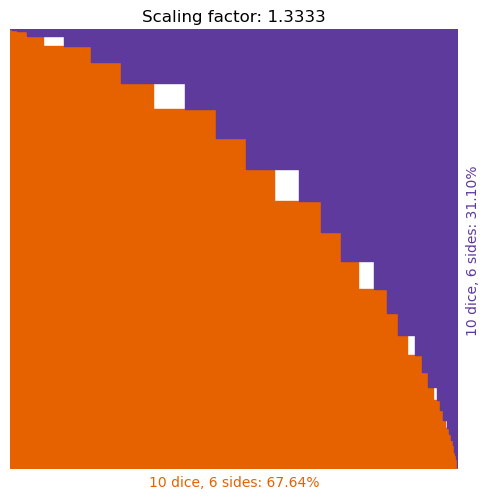

   Scaling factor: 1.3333
10 dice,  6 sides: 67.64%
10 dice,  6 sides: 31.10%
              Tie:  1.26%


In [48]:
show_head_to_head_scaled(players[4], players[4], Fraction(4, 3))

How much of a head start, how many fewer dice, would we need to give the slower player to give them an equal chance of winning?

In [49]:
factor = Fraction(4, 3)
print(f"Scaling factor: {float(factor):.4f}")
print(f"10 dice vs...")
for i in range(5):
    r = show_head_to_head_scaled(players[-1], players[i], Fraction(4, 3), False)
    print(f"{players[i].dice:>2} dice: {float(r[0]):.2%}, {float(r[1]):.2%}, {float(r[2]):.2%}")

Scaling factor: 1.3333
10 dice vs...
 6 dice: 51.33%, 47.23%, 1.44%
 7 dice: 56.57%, 42.02%, 1.41%
 8 dice: 60.88%, 37.75%, 1.37%
 9 dice: 64.51%, 34.17%, 1.32%
10 dice: 67.64%, 31.10%, 1.26%


Not even when they start with six dice would we expect the slower player, on average, to beat a player starting with ten dice who is one-third faster!

The floor I had in my head from the start is eight dice — I imagine a slower player might feel comfortable accepting an advantage of one or two fewer dice at most. How much faster would a player with ten dice need to be to balance out the slower player starting with eight dice?

In [50]:
print("10 dice vs. 8 dice")
for i in range(11):
    factor = ONE + Fraction(i, 50)
    r = show_head_to_head_scaled(players[4], players[2], factor, False)
    print(f"Scaling factor {float(factor):.2f}: {float(r[0]):.2%}, {float(r[1]):.2%}, {float(r[2]):.2%}")

10 dice vs. 8 dice
Scaling factor 1.00: 41.22%, 53.93%, 4.85%
Scaling factor 1.02: 46.07%, 53.93%, 0.00%
Scaling factor 1.04: 46.11%, 53.88%, 0.02%
Scaling factor 1.06: 46.80%, 53.20%, 0.00%
Scaling factor 1.08: 48.19%, 51.80%, 0.01%
Scaling factor 1.10: 49.36%, 50.05%, 0.59%
Scaling factor 1.12: 50.82%, 49.17%, 0.01%
Scaling factor 1.14: 51.77%, 48.23%, 0.00%
Scaling factor 1.16: 52.97%, 47.03%, 0.01%
Scaling factor 1.18: 53.87%, 46.13%, 0.00%
Scaling factor 1.20: 54.65%, 44.47%, 0.88%


Looks like a little over 10% faster is where the players' chances are even.

What I'm taking away from this is that if only one type of dice is available, winning chances in Tenzi are likely to vary more due to how fast a player is than due to how many dice a player starts with.

Of course, if you happen to have a stash of ten-sided dice lying around, go wild:

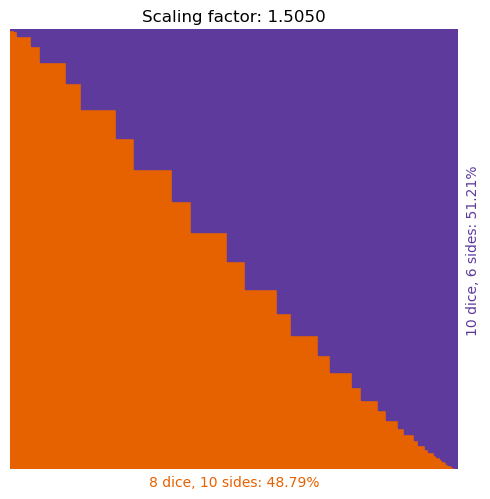

   Scaling factor: 1.5050
 8 dice, 10 sides: 48.79%
10 dice,  6 sides: 51.21%
              Tie:  0.00%


In [51]:
show_head_to_head_scaled(Player(8, 10), Player(10, 6), Fraction(301, 200))

In fact, that gives me an idea for a house rule. Anyone who wins two games in a row has a d10 added to their dice for the next game. I haven't done the math, but it feels about right. =)

## Extras

### Challenges
- Repeat the first phase (first roll of all dice) but with more dice, and give them a large number of faces. How many different states do you have after adding each die? What is this sequence of numbers?
- Expand the scaled simulation to handle more than two players. At what number of players do you expect a player slower than the rest will get discouraged by their lack of wins? How might you take a theoretical approach that handles more than two players?
- Adjust the probability distribution to allow changing the target number after any roll. For example, if your first roll results in 2 of your target, but on your second roll (of 8 dice) you get none of the target and 3 of a different number, you would change the target to that new number. On the following turn, you would re-roll all 7 dice not matching the new target.

### Did I actually analyze the problem in the order presented here?
No! Ha. What? No. As soon as I learned about the game, I was curious what the expected number of rolls was. I wanted to compute it directly before simulating it, and the most fun part was working out how to process the dice from the first roll one at a time. Then as I looked at the distribution, I realized I didn't have a feel for how competitive the game would be between kids of various ages. That led me to think about doing a kind of sensitivity analysis.

### Why use fractions?
<a href="https://github.com/RobinFiveWords/chutes-and-ladders/blob/main/chutes_and_ladders.ipynb">Out of habit?</a> As long as the computer can keep up, I like keeping values exact until we need to round them for display. Particularly for small fractions, seeing the exact denominator can provide meaning that would be lost looking at a decimal.

### Versions
| Version | Date       | Description |
| ------- | ---------- | ----------- |
| 0.1     | 2024-08-18 | Initial version. Will leave unchanged through end of <a href="https://some.3b1b.co/">SoMEπ</a>. |